# Decision Trees


In [1]:
from __future__ import print_function
import os

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

# from sklearnex import patch_sklearn
# patch_sklearn()

In [2]:
import pandas as pd
filepath = os.sep.join( ['pd_speech_features.csv'])
data = pd.read_csv(filepath, sep=',')
data.head()
data= data.drop('id',axis=1)

In [3]:
data.dtypes

gender                         int64
PPE                          float64
DFA                          float64
RPDE                         float64
numPulses                      int64
                              ...   
tqwt_kurtosisValue_dec_33    float64
tqwt_kurtosisValue_dec_34    float64
tqwt_kurtosisValue_dec_35    float64
tqwt_kurtosisValue_dec_36    float64
class                          int64
Length: 754, dtype: object

Convert the color feature to an integer. This is a quick way to do it using Pandas.

In [4]:
# All data columns except for class
feature_cols = [x for x in data.columns if x not in 'class']

In [32]:
# Split the data into two parts with 1000 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=5, train_size=0.7, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['class']))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'class']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'class']
print(y_train.value_counts(normalize=True).sort_index())
print(y_test.value_counts(normalize=True).sort_index())

0    0.253308
1    0.746692
Name: class, dtype: float64
0    0.255507
1    0.744493
Name: class, dtype: float64


## Decision Tree - baseline

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
def specificity_score(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    return cf[0,0]/(cf[0,0]+cf[0,1])

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'specificity': specificity_score(y_true, y_pred),
                      'balancedAccuracyScore':balanced_accuracy_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                     name=label)

In [33]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)
print(dt.tree_.node_count, dt.tree_.max_depth)
# The error on the training and test data sets
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)
print(confusion_matrix(y_train, y_train_pred))
print(confusion_matrix(y_test, y_test_pred))
train_test_full_error

67 12
[[134   0]
 [  0 395]]
[[ 36  22]
 [ 25 144]]


,train,test
accuracy,1.0,0.792952
precision,1.0,0.867470
recall,1.0,0.852071
specificity,1.0,0.620690
balancedAccuracyScore,1.0,0.736380
f1,1.0,0.859701


## Decision Tree - GridSearchCV
### 1. Base GridSearchCV

In [11]:
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)
print(GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth)

y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)
print(confusion_matrix(y_train, y_train_pred_gr))
print(confusion_matrix(y_test, y_test_pred_gr))
train_test_gr_error

31 5
[[112  22]
 [  4 391]]
[[ 35  23]
 [ 12 157]]


,train,test
accuracy,0.950851,0.845815
precision,0.946731,0.872222
recall,0.989873,0.928994
specificity,0.835821,0.603448
balancedAccuracyScore,0.912847,0.766221
f1,0.967822,0.899713


### 2. Add parameter

In [21]:
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1),
              'max_features': range(1, len(dt.feature_importances_)+1),
              'min_samples_split':range(1,5),
              'min_samples_leaf':range(1,5),
              }

In [25]:
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1),
              'max_features': range(1, len(dt.feature_importances_)+1),
              }

In [26]:

GR2 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR2 = GR2.fit(X_train, y_train)
print(GR2.best_estimator_.tree_.node_count, GR2.best_estimator_.tree_.max_depth)

y_train_pred_gr2 = GR2.predict(X_train)
y_test_pred_gr2 = GR2.predict(X_test)

train_test_gr_error2 = pd.concat([measure_error(y_train, y_train_pred_gr2, 'train'),
                                 measure_error(y_test, y_test_pred_gr2, 'test')],
                                axis=1)
print(confusion_matrix(y_train, y_train_pred_gr2))
print(confusion_matrix(y_test, y_test_pred_gr2))
train_test_gr_error2

37 6
[[112  22]
 [  1 394]]
[[ 32  26]
 [ 13 156]]


,train,test
accuracy,0.956522,0.828194
precision,0.947115,0.857143
recall,0.997468,0.923077
specificity,0.835821,0.551724
balancedAccuracyScore,0.916645,0.737401
f1,0.971640,0.888889


In [27]:
try:
    import pydotplus
    pydotplus_installed = True

except:
    print('PyDotPlus must be installed to execute the remainder of the cells associated with this question.')
    print('Please see the instructions for this question for details.')
    pydotplus_installed = False


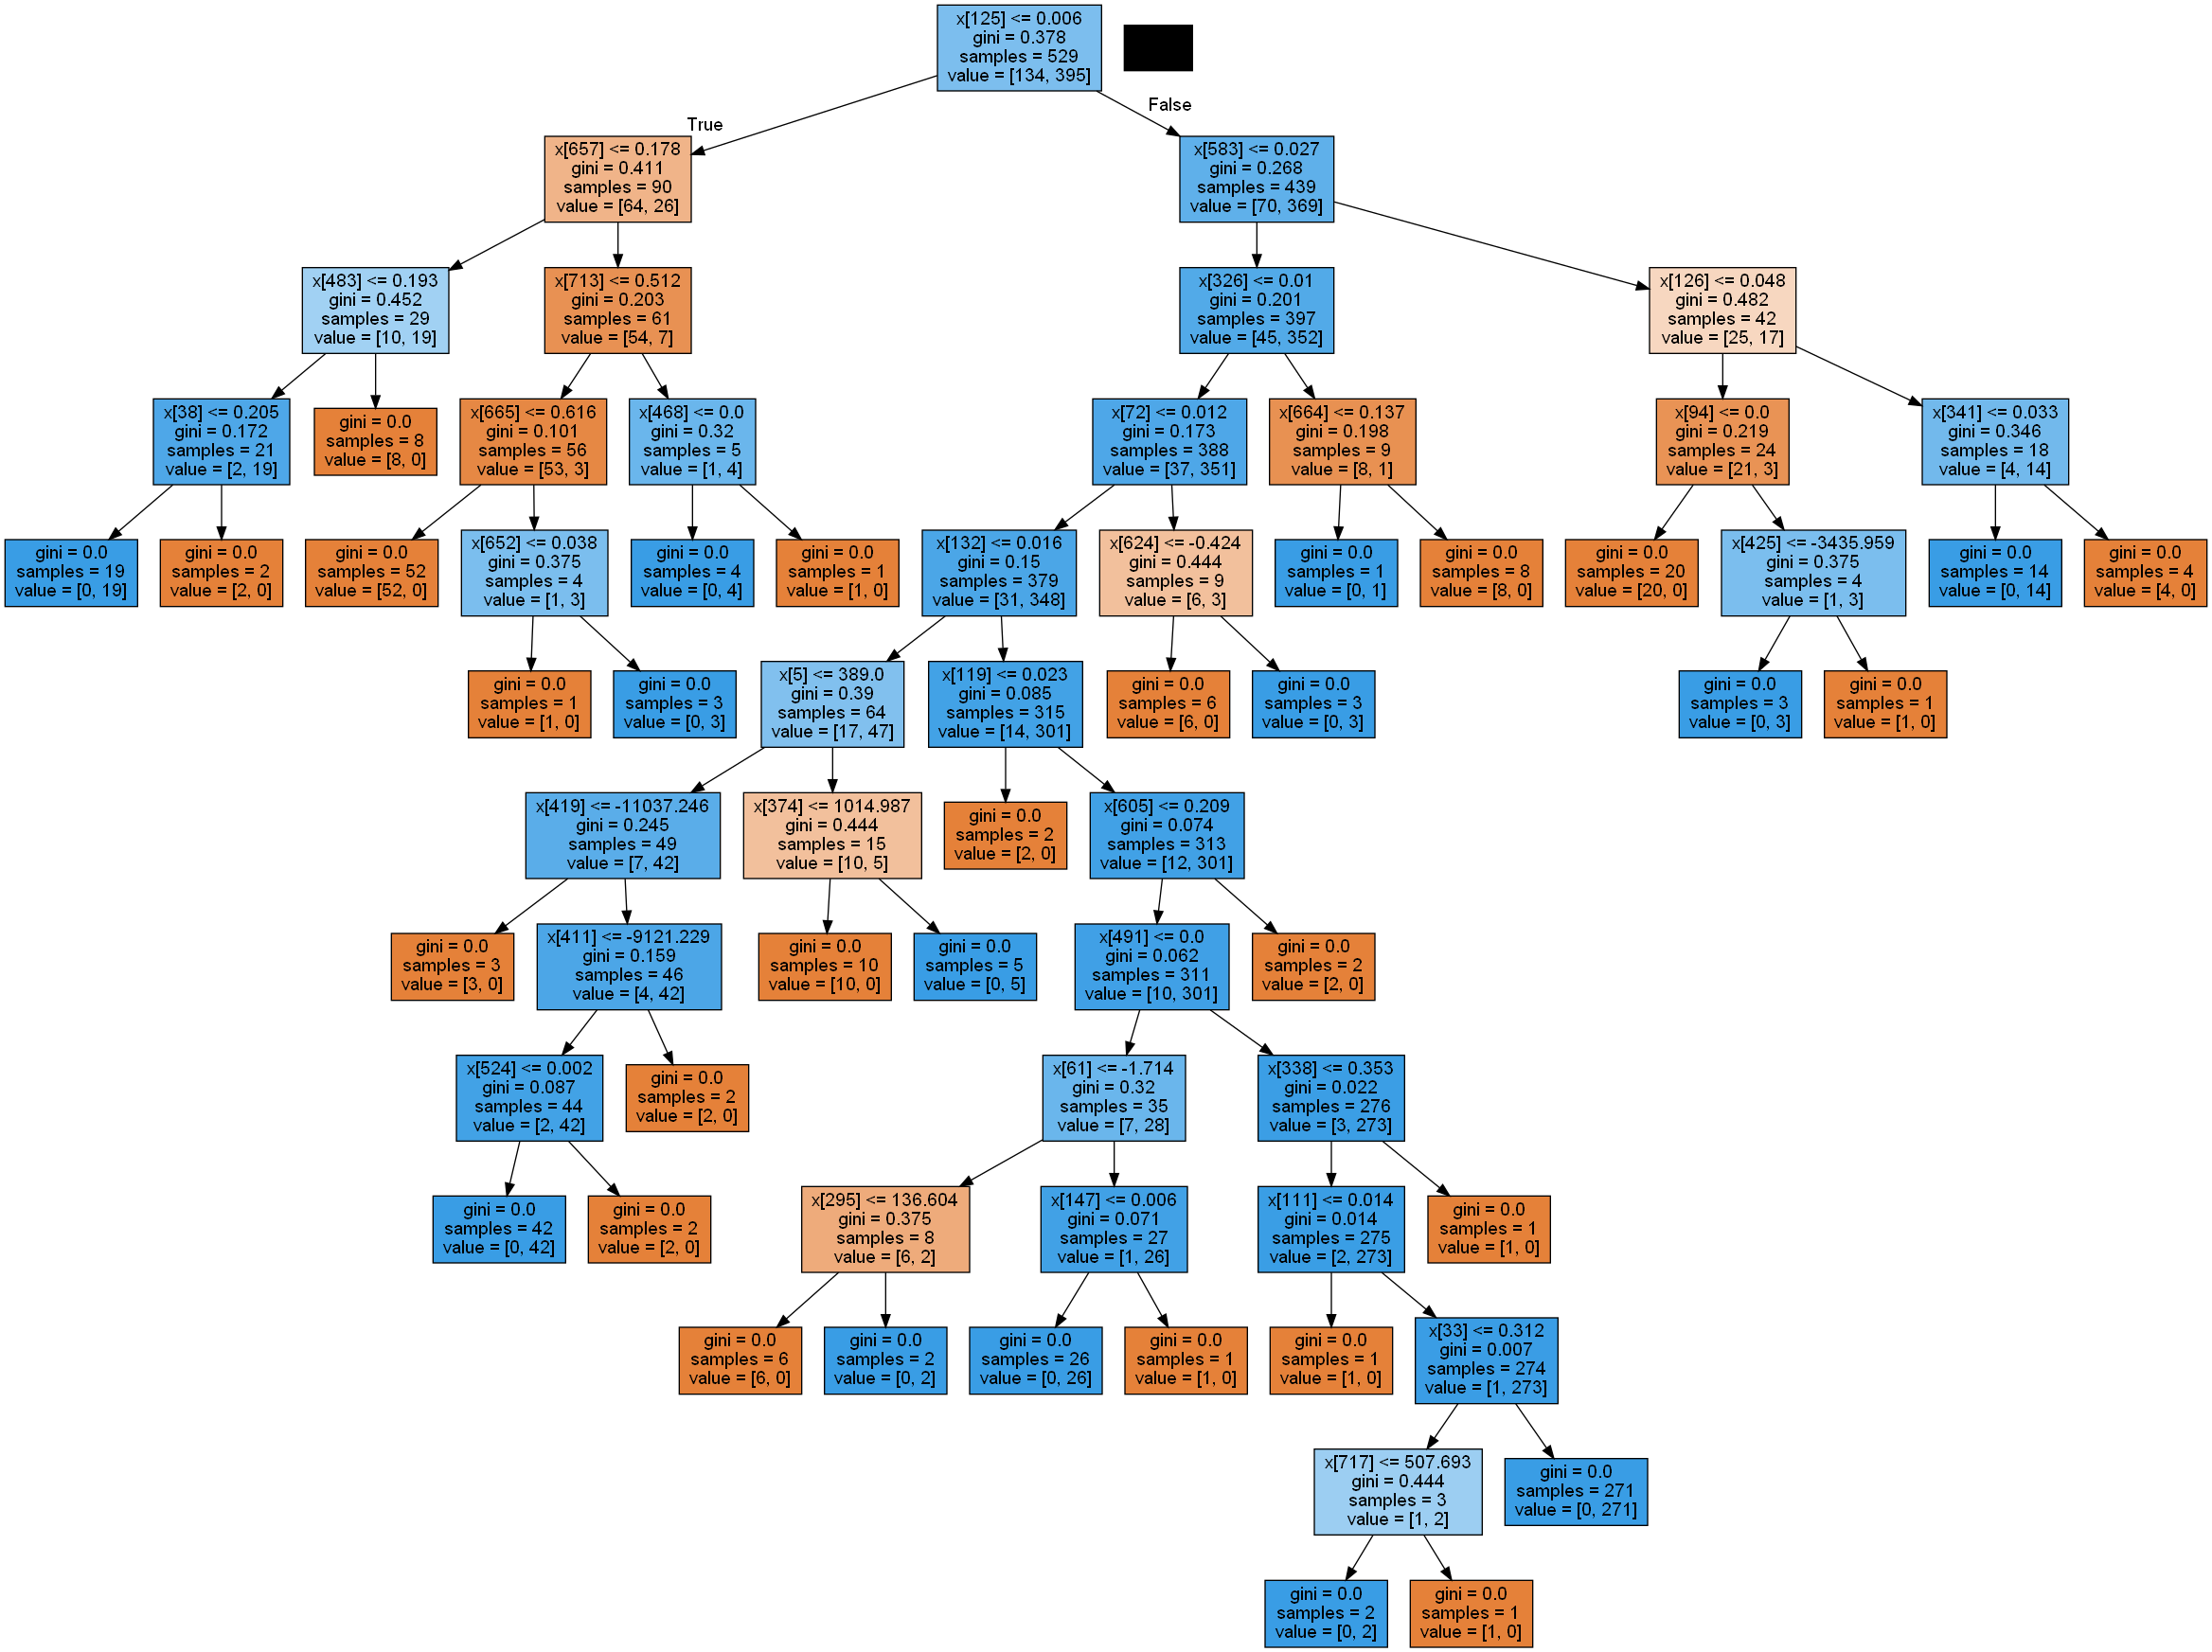

In [30]:

from IPython.core.display import Image
from sklearn.tree import export_graphviz
from io import StringIO

if pydotplus_installed:

    # Create an output destination for the file
    dot_data = StringIO()

    export_graphviz(dt, out_file=dot_data, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # View the tree image
    filename = 'tree.png'
    graph.write_png(filename)
    img = Image(filename=filename)
    display(img)

else:
    print('This cell not executed because PyDotPlus could not be loaded.')

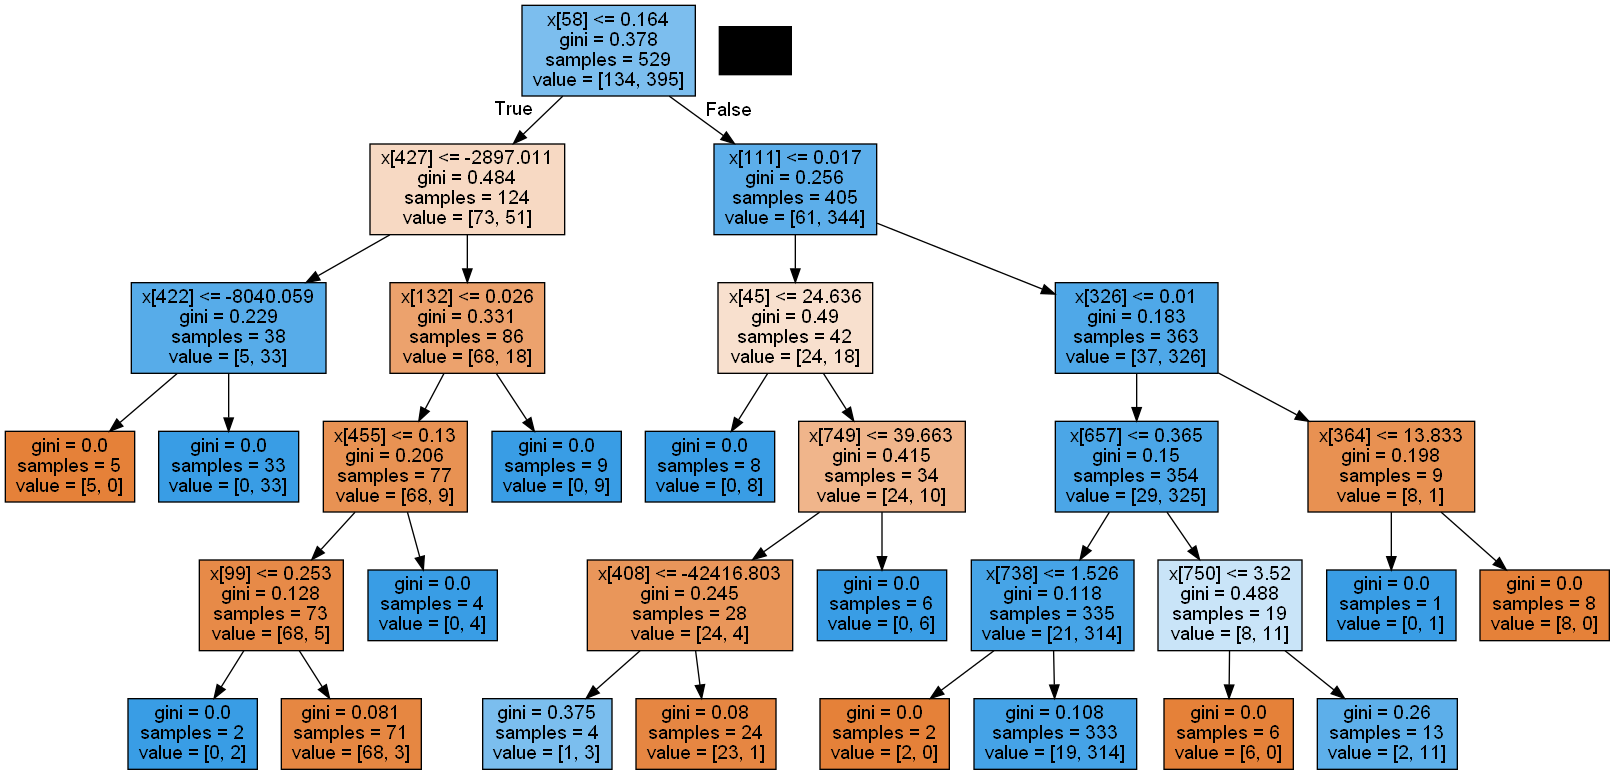

In [31]:
if pydotplus_installed:

    # Create an output destination for the file
    dot_data = StringIO()

    export_graphviz(GR.best_estimator_, out_file=dot_data, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # View the tree image
    filename = 'tree_prune.png'
    graph.write_png(filename)
    img = Image(filename=filename)
    display(img)

else:
    print('This cell not executed because PyDotPlus could not be loaded.')

### 1. 데이터 선택 및 분석
(https://www.kaggle.com/datasets/dipayanbiswas/parkinsons-disease-speech-signal-features)
사용한 데이터는 파킨슨 병 예측을 위한 데이터셋으로, physicianâ€™s examination을 통해 얻은 환자의 speech data에 Time Frequency Features, Mel Frequency Cepstral Coefficients (MFCCs) 등 다양한 알고리즘을 적용하여 임상적으로 유용한 정보를 추출한 데이터셋이다. 데이터의 개수는 756개, feature column의 개수는 754개이다. 파킨슨 병이 걸린 사람, 안 걸린 사람의 음성에서 추출된 feature에는 Baseline, Intensity, Formant, Bandwidth, Vocal Fold, MFCC, Wavelet 등 대부분 오디오 신호에서 추출되어, 미리 유효성 있는 feature들로만 전처리되어 특별한 전처리가 필요없다.
y_label로 사용될 'class' column은 파킨슨 병에 걸렸는지, 안걸렸는지에 대해 binary로 전처리되었다.  해당 데이터는 파킨슨 병에 걸린 사람의 데이터 수가 걸리지 않은 사람의 데이터 수보다 훨씬 많기에 데이터의 분포가 불균형하다.


### 2. NN
### 3. Naive Bayes
### 4. SVM
### 5. Decision Tree
‘Parkinson's Disease (PD) classification’ 데이터셋을 Decision Tree 모델로 학습시키고 테스트해보았다. Decision Tree는 데이터에 있는 규칙을 학습을 통해서 자동으로 찾아내 트리 기반의 분류 규칙을 만드는 것이다. if, then, else를 기반으로 예측을 위한 규칙을 만들어 그 트리를 따라가면 결과를 도출할 수 있다. 결정 트리에서는 데이터의 어떤 기준을 바탕으로 규칙을 만들 것인지가 알고리즘의 성능을 크게 좌우하게 된다.

(1) Base Algorithm
먼저, 가장 기본 알고리즘으로 모델을 훈련시켜보았다. Decision Tree algorithm은 데이터 분산에 민감하지 않기 때문에 feature Scaling이나 preprocessing을 진행할 필요가 없어 다른 처리를 하지 않았다. 또한, 사용한 데이터가 의료 데이터의 특성상 ylabel feature의 value가 불균형하기 때문에 해당 비율을 유지하면서 데이터를 샘플링하기 위해 StratifiedShuffleSplit를 사용했다. 그 결과, 3:7로 나눈 test data와 train data의 ylabel 비가 전체 데이터와 똑같이 0.25:0.75정도로 잘 나눠진 것을 확인할 수 있었다.
데이터를 Base algorithm에 fit해 트리를 빌드한 결과, tree node는 67개, max depth는 12의 값이 나왔고 정확도는 아래와 같이 나왔다.

| Base             | train | test   |
|------------------|-------|--------|
| accuracy         | 1.0   | 0.7929 |
| precision        | 1.0   | 0.8674 |
| recall           | 1.0   | 0.8520 |
| f1               | 1.0   | 0.8597 |
| specificity      | 1.0   | 0.7363 |
| balancedAcurracy | 1.0   | 0.8597 |

결과를 분석해보면, train dataset의 정확도는 모두 1.0으로, test dataset의 정확도보다 훨씬 높은 것으로 볼 수 있다. 이는 Decision Tree의 문제점인 과적합으로 인한 것으로 보인다.

(2) Improved Algorithm
처음에 실행한 base algorithm을 개선시키기 위해 문제점을 분석하고, 성능을 향상시켜보겠다.
Decision Tree의 마지막 노드의 결과를 도출할 때 100% pure한 정답을 도출하려면 트리의 깊이가 깊어지고 overfit이 생길 수밖에 없다. 따라서 한 번 트리를 빌드시킨 후 prune 하는 과정을 거쳐야한다. 위에서 base 알고리즘으로 트리를 빌드시켜보니 과적합의 문제가 있었다. 따라서 먼저 GridSearchCV를 이용해 max_depth와 max_features 값을 조정해보며 tree를 pruning해보았다.
데이터를 최대깊이와 최대 피처를 조정하며 pruning한 결과, tree node는 31개, max depth는 5의 값이 나왔고 정확도는 아래와 같이 나왔다.

| Base grid        | train  | test   |
|------------------|--------|--------|
| accuracy         | 0.9508 | 0.8458 |
| precision        | 0.9467 | 0.8722 |
| recall           | 0.9898 | 0.9289 |
| f1               | 0.9678 | 0.8997 |
| specificity      | 0.8358 | 0.6034 |
| balancedAcurracy | 0.9128 | 0.7662 |


기존 base algorithm과 비교했을때보다 유의미한 성능개선을 보여주었지만, 더 개선할 수 있는 방법을 고민했다. 이에 다른 파라미터들도 함께 조정하고, max_depth도 2만큼 늘리는 것이 아닌, 1만큼 늘려서 많은 경우의 GridSearchCV를 시행하였다.
GridSearchCV를 이용해 교차검증과, 최적의 하이퍼파라미터 튜닝을 하고자 했다.
데이터를 최대깊이, 최대 피처, 노드를 분할하기 위한 최소한의 샘플 데이터 수, 말단 노드가 되기 위한 최소한의 샘플 데이터 수를 조정하며 pruning한 결과, tree node는 37개, max depth는 6의 값이 나왔고 정확도는 아래와 같이 나왔다.

| Second grid      | train  | test   |
|------------------|--------|--------|
| accuracy         | 0.9565 | 0.8281 |
| precision        | 0.9471 | 0.8571 |
| recall           | 0.9974 | 0.9230 |
| f1               | 0.9716 | 0.8888 |
| specificity      | 0.8358 | 0.5517 |
| balancedAcurracy | 0.9166 | 0.7374 |

노드를 분할하기 위한 최소한의 샘플 데이터 수, 말단 노드가 되기 위한 최소한의 샘플 데이터 수를 파라미터로 조정하고, 안하고는 큰 유의미한 차이를 보이지 않았다. 가장 중요한 max depth를 조정해본 결과, 두번째 알고리즘보다 향상된 결과를 도출할 수 없었는데, 이는 train을 시킬 때 Brueforce 방법이 아닌, 각 노드에서의 최적값을 찾아내는 휴리스틱 기법인 탐욕법을 기반으로 하고 있어 잘못 search 된 것으로 보인다. 또한 파킨슨병에 실제로 이환된 사람이 검사를 받았을 때 양성 판정을 받는 비율인 민감도와 이환되지 않은 정상인이 검사를 받았을 때 음성 판정을 받는 비율인 특이도가 매우 낮은 수치를 보인다.

(3) Result
모든 알고리즘 결과에서 볼 수 있듯이, 해당 데이터에서는, 파킨슨 병에 걸린 사람의 데이터 수보다 걸리지 않은 사람의 데이터 수가 훨씬 많기에(사용한 데이터는 약 1:3의 비율) 실제 True인 것 중에서 모델이 True라고 예측한 recall score가 다른 score보다 가장 높은 것을 볼 수 있었다. 또한, 데이터의 label이 불균형 구조이므로, Precision과 recall score의 조화평균인 F1 score이 모델의 성능을 가장 잘 표현한다고 할 수 있다.
따라서 가장 좋은 성능은 tree node가 31개일때, max depth가 5일때로, Base algorithm보다 단순한, pruning된 트리 구조가 도출되었다.

Decision Tree는 해석하기 쉽고, 트리를 그릴 수 있어서 시각적인 inspection이 가능하다는 장점이 있다. 또한, 이후 추가 개발에서 insight를 얻기 쉽기 때문에, 이와 같은 의료 데이터의 경우, 정확도를 우선하는게 아닌 분석을 위해서라면 사용하는 데 큰 이점을 가진다.


### 6. Conclusion
4가지 NN, naive bayes, svm, decision tree 알고리즘으로 데이터를 훈련시키고 테스트한 결과, 가장 성능이 좋은 알고리즘은 -- 이었다.
이는 ----때문이라고 판단되며,

(최적 기법으로 선정된 알고리즘의 우월성 주장(Claim)를 정성적으로 명확히 설명(Theoretical Evidence))
(나머지 알고리즘이 해당 알고리즘보다 성능이 낮은 이유 작성)

결론적으로, 파킨슨 병 분류에 --- 알고리즘을 사용하면, 병의 유무의 진단을 빠르고 정확도 높게 할 수 있을 것이다.
이는 부족한 수의 의료계 종사자분들의 업무강도를 확실히 낮출 수 있으며, 의료 서비스 단가를 낮추어 모든 사람들이 서비스를 누릴 수 있을 것이다. 또한 환자의 Speech data를 이용해서 분석을 진행하기 때문에, 많은 환자들이 병원에 가지 않고도 edge device에서 간편하게 파킨슨 병의 발병을 예측할 수 있을 것으로 기대된다.
